# 1. Run Single Cap Tag Report

Run a cap tag report (same output as in Excel).
    
**Inputs** 
1. PR number and revision in form: PR_rev, i.e. '1-IWH6ME_2'
2. Directory to write cap tag report .csv file to, i.e. 'C:\\Users\\wb5888\\Documents\\Cap Tags'

**Outputs**
1. On-screen cap tag report
2. Report exported as .csv file with name CP_PR_rev.csv, i.e. '1-IWH6ME_2.csv' to directory provided above

### Input PR_rev and specify directory

In [32]:
%matplotlib inline
import CapTags as ct
import numpy as np
import datetime as dt
import pandas as pd

pr_rev = '1-J6QXR7_1'

write_dir = 'C:\\Users\\wb5888\\Documents\\Cap Tags'

### View Report

View report that will be exported.

In [33]:
report = ct.get_report(pr_rev)
print('found {} accounts.'.format(len(np.unique(report.AccountID))))
report

found 1 accounts.


,CustomerName,CustomerID,LDC_Account,AccountID,UIDaccount,MarketCode,ContractID,Revision,StartTime,StopTime,TagType,Tag,SourceType,TimeStamp
0,STRATUS EQUITIES LLC,1-65DLUP,51794158006_139261009,NEPOOL_CLP_51794158006_139261009,1544381,NEPOOL,1-J6QXR7,1,2019-06-01,2020-05-31 23:59:59,CAPACITY_TAG_OVRD,35.498,H,2019-07-09 12:51:17
1,STRATUS EQUITIES LLC,1-65DLUP,51794158006_139261009,NEPOOL_CLP_51794158006_139261009,1544381,NEPOOL,1-J6QXR7,1,2020-06-01,2021-05-31 23:59:59,CAPACITY_TAG_OVRD,35.498,S,2019-07-09 12:51:17
2,STRATUS EQUITIES LLC,1-65DLUP,51794158006_139261009,NEPOOL_CLP_51794158006_139261009,1544381,NEPOOL,1-J6QXR7,1,2021-06-01,2031-05-31 23:59:59,CAPACITY_TAG_OVRD,35.498,S,2019-07-09 12:51:17


### Check Dates

Ensure tags for all meters cover PR start and end dates.

In [34]:
date_errors = ct.checkPRdates(report, pr_rev)

cap tags cover PR start & end dates for all accts in 1-J6QXR7_1


In [4]:
date_errors[0]

,meter
estimated tag,51564453082_428832003


# Offer Summary

Download forecasts (~4s *per meter*) compare cap to peaks (both actual peak and CP). Graph forecasts

In [35]:
meters, idr_dir = ct.download_idr(pr_rev, report, write_dir)

created directory: C:\Users\wb5888\Documents\Cap Tags\1-J6QXR7_1_CH3
downloading forecasts for 1 meters...
expect to take 3.4 seconds.
download complete


In [36]:
master_idr = ct.merge_idr(meters, idr_dir)
master_idr.head()

importing and merging .csv's...
read in and merged ch 3.


,NEPOOL_CLP_51794158006_139261009
time,
2019-01-01 01:00:00,3.674018
2019-01-01 02:00:00,3.589192
2019-01-01 03:00:00,3.509668
2019-01-01 04:00:00,3.565335
2019-01-01 05:00:00,3.552081


**offer_summary()** function takes parameters **min_cp** and **min_diff**, which are the minimum tag values and minimum percent differences to look at.

                                  Annual_Use_MWh  Act_Peak      CP     Tag  \
AccountID                                                                    
NEPOOL_CLP_51794158006_139261009          63.925    27.521  20.995  35.498   

                                  Act_Tag_Diff  Cap_Tag_Diff  
AccountID                                                     
NEPOOL_CLP_51794158006_139261009    -22.471689    -40.855823  
PR has total usage of 63.925 MWh.
PR has an estimated tag total of 35.498 kWh.
PR has CP peak sum of 20.995 kWh.
PR has peak (sum(act_peak)) of 27.521 kWh, and 1 meters.
graphing forecasts...


,Annual_Use_MWh,Act_Peak,CP,Tag,Act_Tag_Diff,Cap_Tag_Diff
AccountID,,,,,,
NEPOOL_CLP_51794158006_139261009,63.925,27.521,20.995,35.498,-22.471689,-40.855823


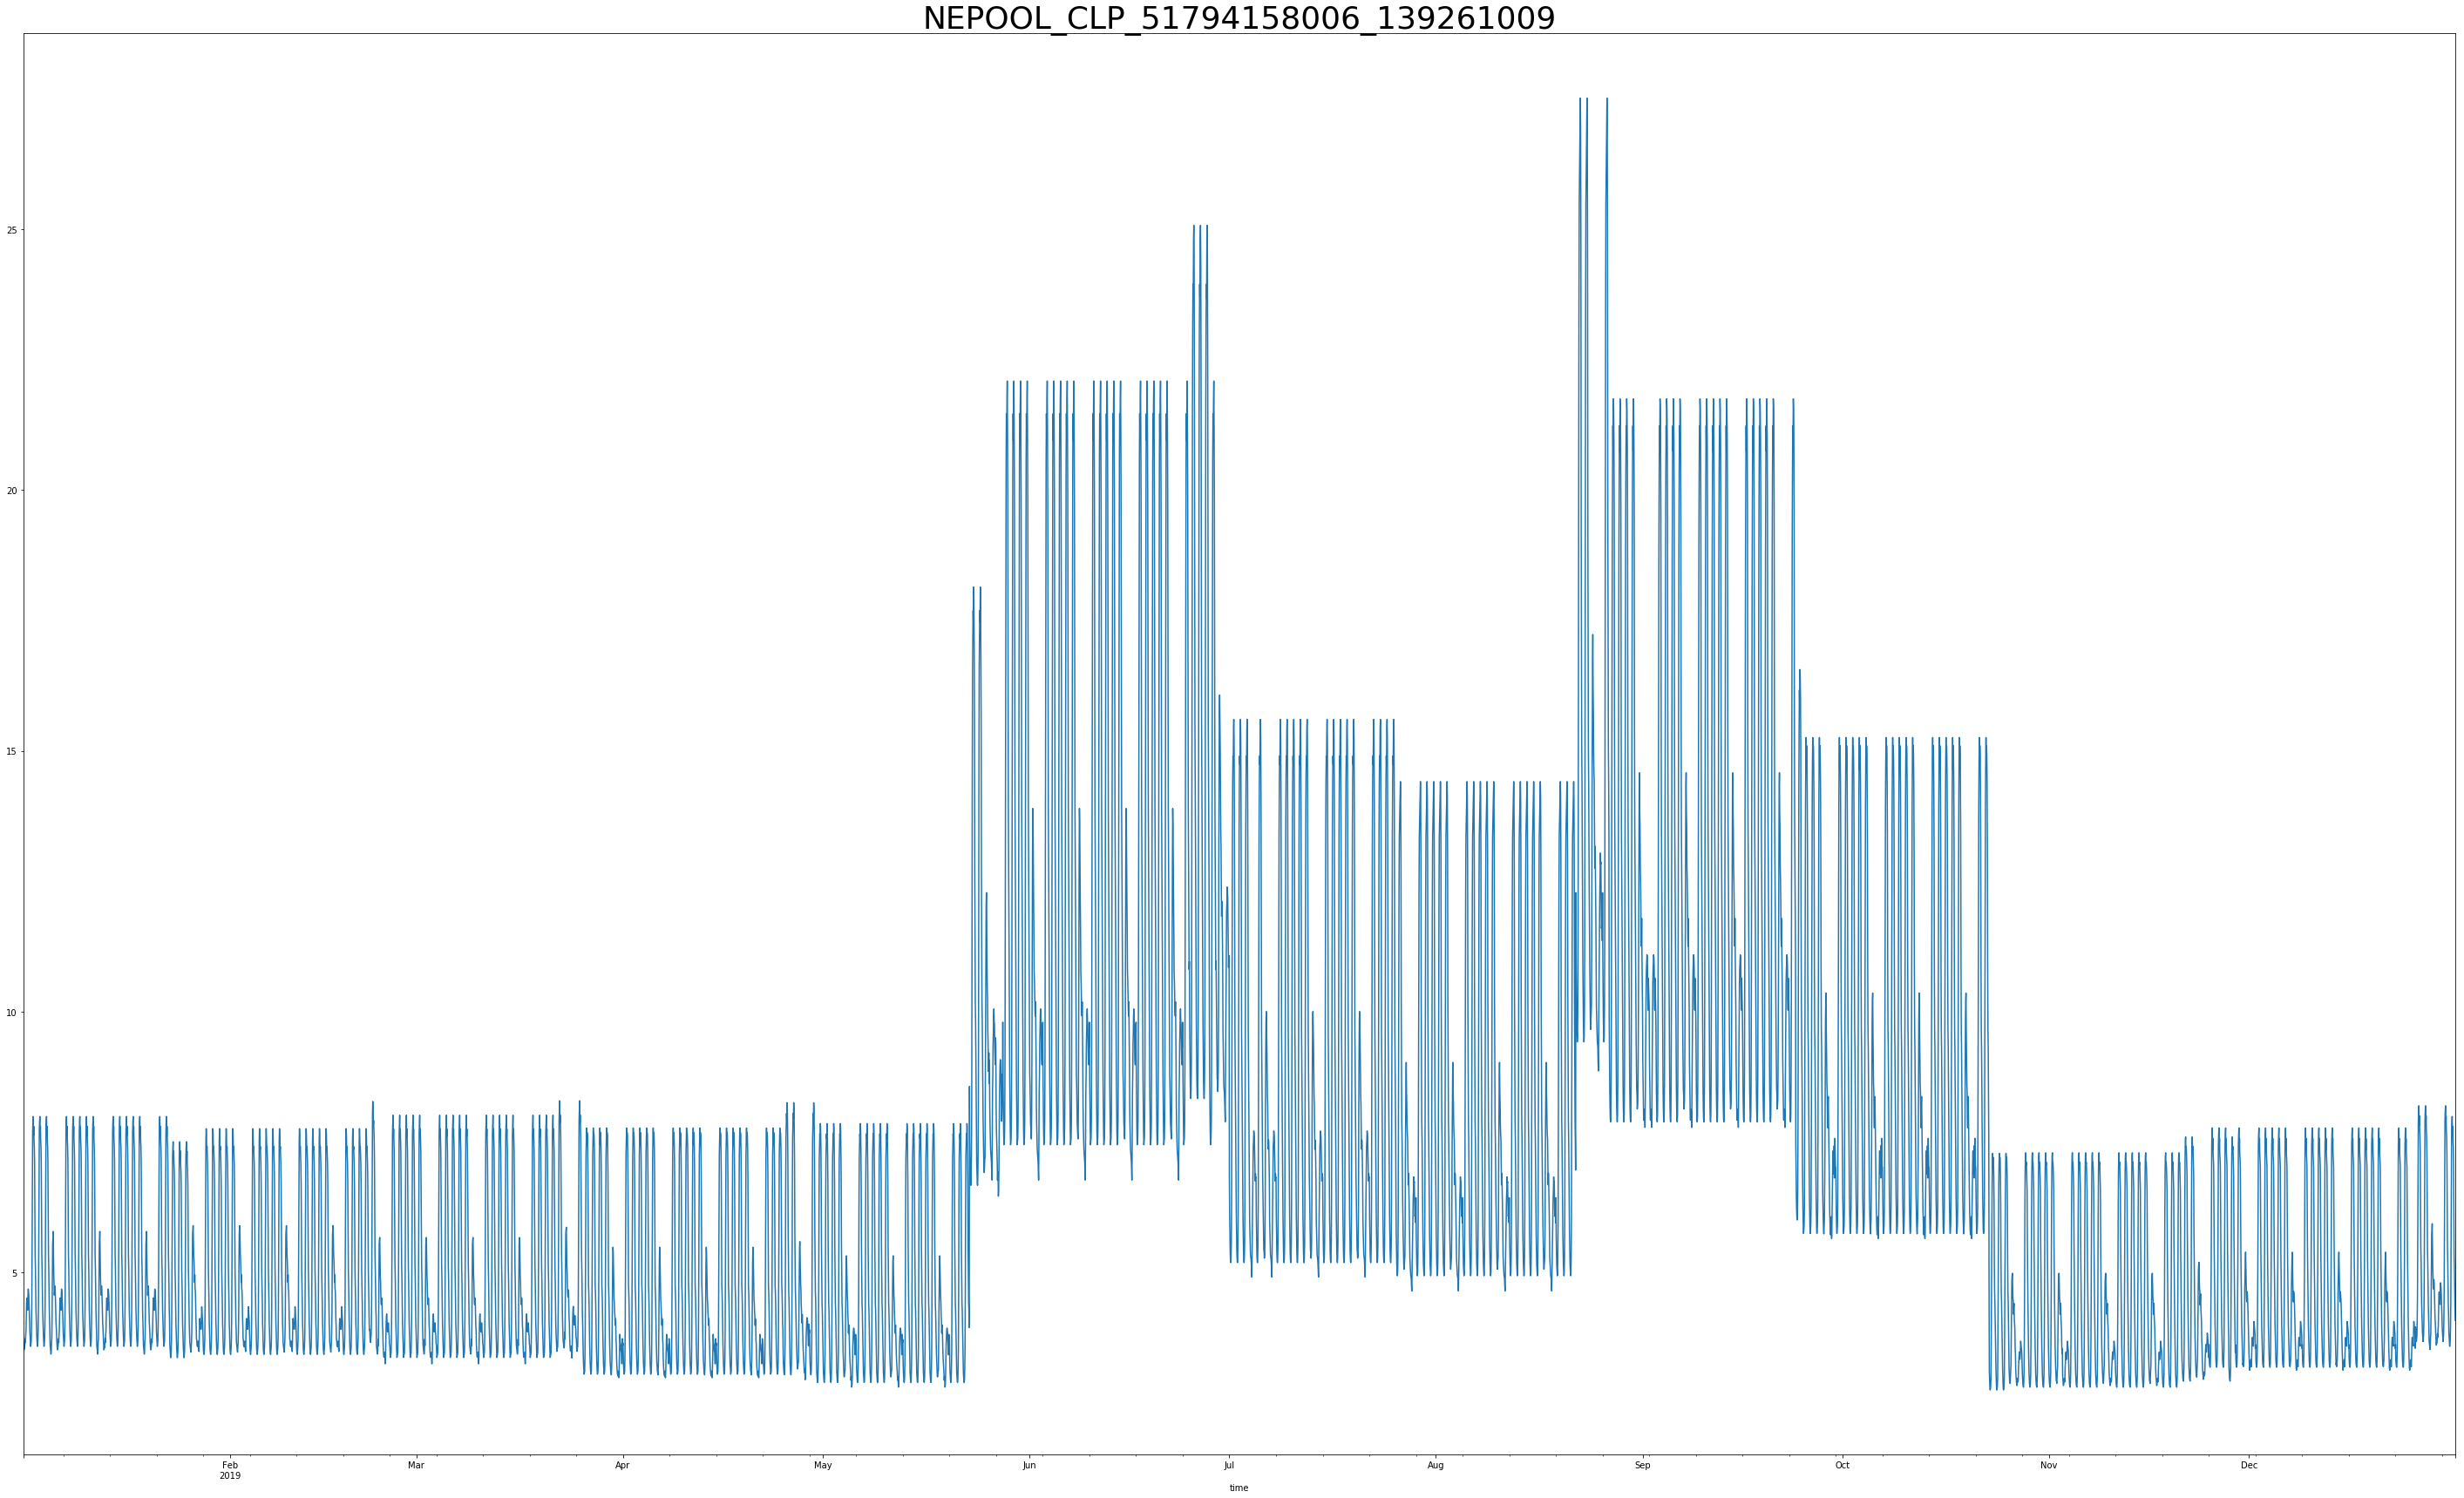

In [37]:
ct.offer_summary(master_idr, report, 5, 5)

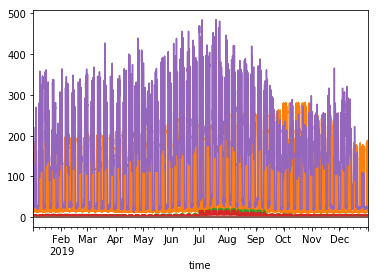

In [6]:
for m in master_idr.columns:
    tmp = master_idr[m]
    tmp.plot(y = m)

### Export Report to *write_dir*

If everything looks good report can be exported to the directory specified above.

In [38]:
ct.export_report(pr_rev, write_dir)

saved file as CP_1-J6QXR7_1.csv


# Additions

1. Get all cap tags and check time difference between Start Times (should be one year, tag missing if not)
2. Append errors to rows, or make another summary with errors

In [ ]:
curr = [start.year >= 2018 for start in report.StartTime]
cap = [tag.split('_')[0] == 'CAPACITY' for tag in report.TagType]
cap_summary = report.loc[(curr and cap),['AccountID', 'StartTime', 'StopTime']]
#cap_summary.to_csv('PJM_Ohio_Cap_Summary.csv', header = True, index = False)
#cap_summary

In [ ]:
curr = [start.year >= 2019 for start in report.StartTime]
trans = [tag.split('_')[0] == 'TRANSMISSION' for tag in report.TagType]
trans_summary = report.loc[(curr and trans),['AccountID', 'StartTime', 'StopTime']]
#trans_summary.to_csv('PJM_Ohio_Trans_Summary.csv', header = True, index = False)
#trans_summary

In [ ]:
data_import('NEPOOL_BECO_25831661001.csv')

# Offer Summary Functions

In [ ]:
def download_idr(pr_rev, report):

    subfolder = "_".join([pr_rev, 'CH3'])
    idr_dir = os.path.join(write_dir, subfolder)

    try:
        os.mkdir(idr_dir)
        print('created directory: {}'.format(idr_dir))
    
    except:
        print('dir already created.')
    

    meters = np.unique(report.AccountID)
    n = len(meters)
    time = round(3.4*n, 4)

    print('downloading forecasts for {} meters...'.format(len(np.unique(report.AccountID))))
    print('expect to take {} seconds.'.format(time))
    count = 0

    for index, accts in enumerate(meters):
        idr_file = ''.join([accts, '.csv'])
    
        if idr_file not in os.listdir(idr_dir):
            try:
                pipe_import(idr_file, idr_dir)
    
            except:
                print('error w/ download, acct {}.'.format(accts))
    
        elif idr_file in os.listdir(idr_dir):
            pass
    
        count += 1
        if (count > 0 and count % 5 == 0):
            print('downloaded data for {} out of {} meters...'.format(count, n))
        
    print('download complete')
    return(meters, idr_dir)

In [ ]:
def merge_idr(meters, idr_dir):

    print("importing and merging .csv's...")
    master_idr = pd.DataFrame()

    for accts in meters:
    
        try:
            idr_file = ''.join([accts, '.csv'])
    
            acct_idr = data_import(idr_file, idr_dir)
            acct_idr.columns = [accts]
    
            master_idr = pd.concat([master_idr, acct_idr], axis = 1)
            master_idr.fillna(0, axis = 1)
    
        except:
            print('import error, acct {}.'.format(accts))

        
    print('read in and merged ch 3.')
    master_idr.head()
    master_idr.fillna(0, axis = 1)
    
    return(master_idr)

In [ ]:
def offer_summary(master_idr, report, min_cp, min_diff):

    tag_date = dt.datetime.strptime('2019-08-29 17:00:00', '%Y-%m-%d %H:%M:%S')

    act_max = pd.DataFrame(master_idr.apply(max, axis = 0))
    cp_max = master_idr.loc[master_idr.index == tag_date].reset_index(drop = True).T

    start_yrs = [yr.year == 2019 for yr in report.StartTime]
    cap = report[['AccountID', 'Tag']].loc[start_yrs].reset_index(drop = True)
    cap = cap.set_index('AccountID')

    annual_use = pd.DataFrame(.001*master_idr.apply(sum, axis = 0), columns = ['Annual_Use'])

    peak_data = pd.concat([annual_use, act_max, cp_max, cap], axis = 1).round(decimals = 3)
    peak_data.columns = ['Annual_Use_MWh', 'Act_Peak', 'CP', 'Tag']
    peak_data['Act_Tag_Diff'] = (peak_data.Act_Peak - peak_data.Tag)/peak_data.Tag*100
    peak_data['Cap_Tag_Diff'] = (peak_data.CP - peak_data.Tag)/peak_data.Tag*100

    tot_vol = round(sum(peak_data.Annual_Use_MWh), 4)
    tot_peak = round(sum(peak_data.Act_Peak), 4)
    tot_CP = round(sum(peak_data.CP), 4)
    tag_tot = round(sum(peak_data.Tag), 4)

    print('PR has total usage of {} MWh.'.format(tot_vol))
    print('PR has an estimated tag total of {} kWh.'.format(tag_tot))
    print('PR has CP peak sum of {} kWh.'.format(tot_CP))
    print('PR has peak (sum(act_peak)) of {} kWh, and {} meters.'.format(tot_peak, len(peak_data.index)))
    high_cp = [p > min_cp for p in peak_data.CP]
    big_err = [abs(d) > min_diff for d in peak_data.Cap_Tag_Diff]
    probs = [a and b for a, b in zip(high_cp, big_err)]

    problems = peak_data[probs]
    
    if problems.empty:
        print('no cap tags included - try lowering parameters.')
        return
    
    n = len(problems.index)
    a = math.ceil(math.sqrt(n))
    b = n // a

    if (a * b < n):
        b = math.ceil(n//a)

    fig, axes = plt.subplots(nrows=a, ncols=b, sharex=True, sharey=False, figsize=(50,30))
    
    try:
        axes_list = [item for sublist in axes for item in sublist]
        axes_list = deque(axes_list)
        
    except:
        ax = axes
        
    print('graphing forecasts...')
    
    if n == 1:
        meter = problems.index[0]
        ax.set_title(meter, fontsize = 36);
        plt.rc('font', size = 24)
        meter_df = master_idr.loc[:,meter]
        rec_yr = [a < 2020 for a in meter_df.index.year]
        meter_df[rec_yr].plot(y = meter, ax = ax);
        
    elif n > 1:

        for m in problems.index:

            ax = axes_list.popleft();
            ax.set_title(m, fontsize = 36);
            plt.rc('font', size = 24)
            meter_df = master_idr.loc[:,m]
            rec_yr = [a < 2020 for a in meter_df.index.year]
            meter_df[rec_yr].plot(y = m, ax = ax);
        
    
    return(problems)

In [ ]:
def pipe_import(filename, path):

    account = filename.split('.')[0]
    ch = '3'
    final = ",".join([account, ch])
    write_path = os.path.join(path,filename)

    cmd_prmpt = ["C:\LODESTAR\Bin\intdexp", "-c", "Data Source=TPPE;User ID=tesi_interface;Password=peint88;LSProvider=ODP;",\
                 "-q", "pwrline", "-f", "C:\LODESTAR\cfg\examples\Cfg\lodestar.cfg", "-s", "01/01/2019", "-t", "12/31/2019",\
                 "-dtuse", "PARTIAL", "-d", "hi", final, "-o", write_path]

    x = Popen(cmd_prmpt, stdout = PIPE, stderr = PIPE)
    output, errors = x.communicate()

    
def data_import(file, path):
    
    os.chdir(path)
    data = pd.read_csv(file, header = None, index_col = 0, skiprows = 6)

    data.reset_index(drop = True, inplace = True)
    data.drop(data.columns[[1, 3]], axis = 1, inplace = True)
    data.columns = ['ch3', 'time']
    data.time = pd.to_datetime(data.time)
    data.index = data.time
    data.drop(data.columns[1], axis = 1, inplace = True)
    
    return(data)

In [ ]:
def issue_command(command):
    process = Popen(command, stdout=PIPE, stderr=PIPE, shell=True)
    return process.communicate()

stdout, stderr = issue_command(cmd_prmpt)